In [188]:
import time
import datetime
import json
import requests 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import copy

TimeSeries Class

In [189]:
class TimeSeries():
    def __init__(self, name, description, unit, period, values):
        self.name = name
        self.description = description
        self.unit = unit
        self.period = period
        self.values = values
        self.values_dict = self.get_values_dict()
        self.normalized_values_dict = self.get_normalized_values_dict()
        
    def get_values_dict(self):
        dic = dict()
        for value in self.values:
            dic[datetime.datetime.fromtimestamp(value['x']).date()] = value['y']
        return dic
    
    def get_normalized_values_dict(self):
        dic = dict()
        arr = np.array(list(self.values_dict.values()))
        max_value = arr.max()
        min_value = arr.min()
        
        for k,v in self.values_dict.items():
            value = (v - min_value) / (max_value - min_value)
            dic[k] = value
        return dic

Get timeseries from the API

In [190]:
start_time = time.time()
print("Starting at " + str(datetime.datetime.now()))

urls = []
url_base = 'https://api.blockchain.info/charts/'
url_end_points = ['mempool-count', 'mempool-size', 'estimated-transaction-volume-usd', 
                  'n-transactions-excluding-chains-longer-than-100', 'trade-volume',
                 'market-cap', 'market-price', 'n-transactions', 'total-bitcoins']
url_parameters = '?timespan=213days&format=json&start=2017-09-01'

for url_end_point in url_end_points:
    urls.append(url_base + url_end_point + url_parameters)

timeseries_dict = {}
for url in urls:
    r = requests.get(url = url)
    if r.status_code == 200:
        prices_json_obj = json.loads(r.text)
        timeseries = TimeSeries(prices_json_obj['name'], prices_json_obj['description'],
                               prices_json_obj['unit'], prices_json_obj['period'], 
                               prices_json_obj['values'])
        timeseries_dict[timeseries.name] = timeseries

print("Finished at " + str(datetime.datetime.now()))
print("Total time: --- {0} seconds ---".format(round(time.time() - start_time, 4)))

Starting at 2019-10-24 18:27:09.954887
Finished at 2019-10-24 18:27:14.618968
Total time: --- 4.6644 seconds ---


Plot method

In [173]:
def plot_timeseries(start_date, end_date, timeseries):
    start_date= datetime.datetime.strptime('2017-09-01', "%Y-%m-%d").date()
    end_date= datetime.datetime.strptime('2018-03-31', "%Y-%m-%d").date()

    filtered_dict = {k:v for k,v in timeseries.values_dict.items() if k >= start_date and k <= end_date }
    x = filtered_dict.keys()
    y = filtered_dict.values()

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x, y)
    plt.xlabel(timeseries.period)
    plt.ylabel(timeseries.unit)
    plt.title(timeseries.description)

    format_xdata = mdates.DateFormatter('%m-%d')
    max_yticks = 30
    xloc = plt.MaxNLocator(max_yticks)
    ax.xaxis.set_major_locator(xloc)
    ax.xaxis.set_major_formatter(format_xdata)

    plot_name = 'plots/' + timeseries.name + '_' + str(start_date) + '_' + str(end_date) + '.png'
    fig.savefig(plot_name, dpi=fig.dpi)

In [174]:
start_date= datetime.datetime.strptime('2017-09-01', "%Y-%m-%d").date()
end_date= datetime.datetime.strptime('2018-03-30', "%Y-%m-%d").date()

The name is too long, gotta cut it

In [191]:
timeseries_dict['Number Of Transactions Excluding Chains Longer Than 100'].description = 'The total number of Bitcoin transactions per day excluding those part of long transaction chains. \
excluding coin mixing or possible attempts to manipulate transaction volume.'

transform "Bitcoins in circulation" to "Bitcoins mined daily" timeseries

In [192]:
values_dict = timeseries_dict['Bitcoins in circulation'].values_dict
        
new_timeseries_values_dict = {k:values_dict[k] - values_dict[k + timedelta(days=-1)] for 
                              k,v in values_dict.items()
                             if k + timedelta(days=-1) in values_dict}
new_btc_in_circulation_timeseries = copy.deepcopy(timeseries_dict['Bitcoins in circulation'])

new_btc_in_circulation_timeseries.values_dict = new_timeseries_values_dict
new_btc_in_circulation_timeseries.name = 'Bitcoins mined daily'
new_btc_in_circulation_timeseries.name = 'The number of Bitcoins mined each day'

In [178]:
timeseries_dict[new_btc_in_circulation_timeseries.name] = new_btc_in_circulation_timeseries

In [194]:
del timeseries_dict['Bitcoins in circulation']

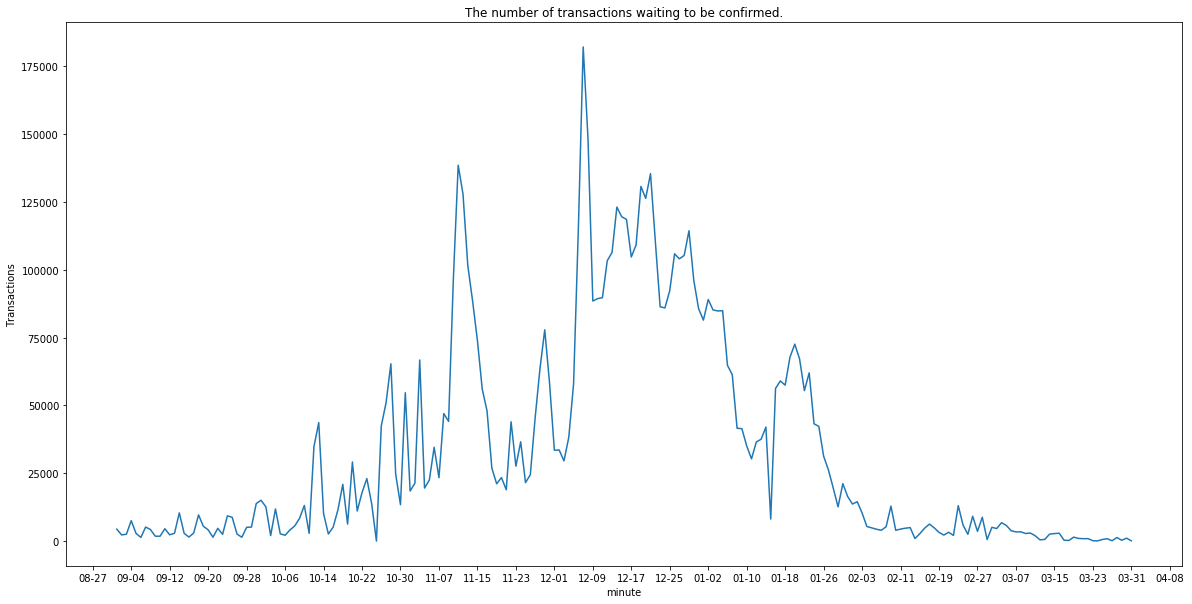

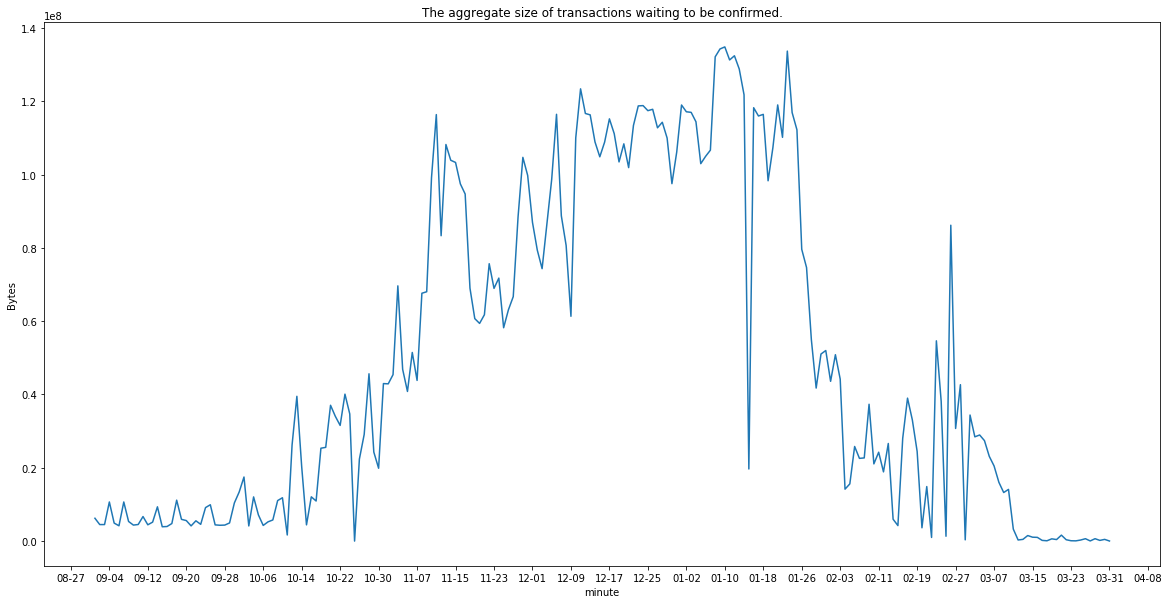

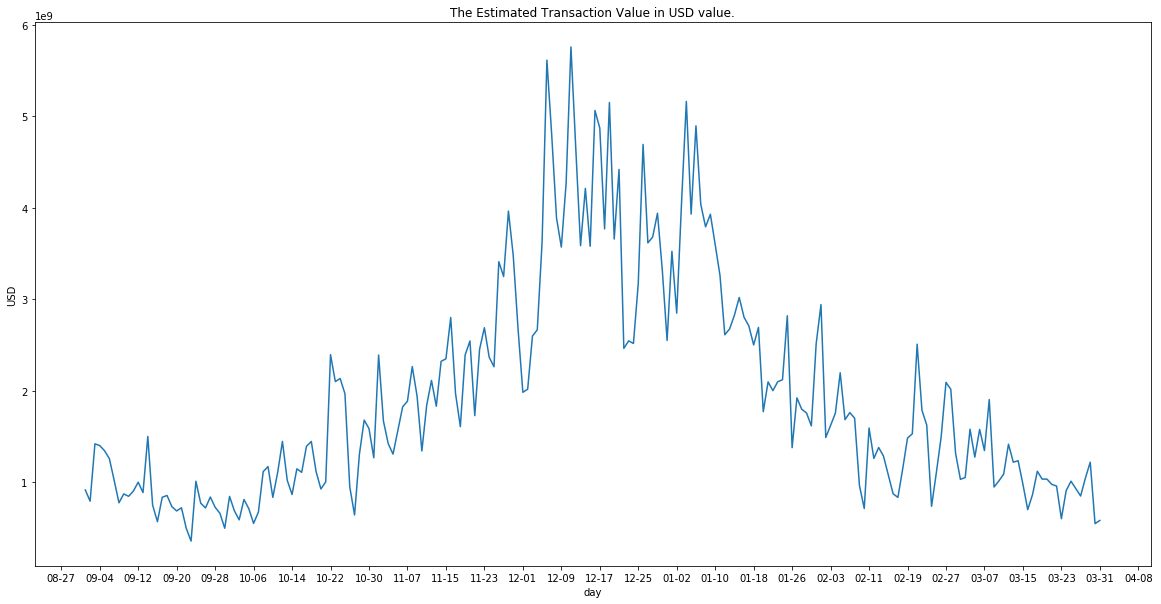

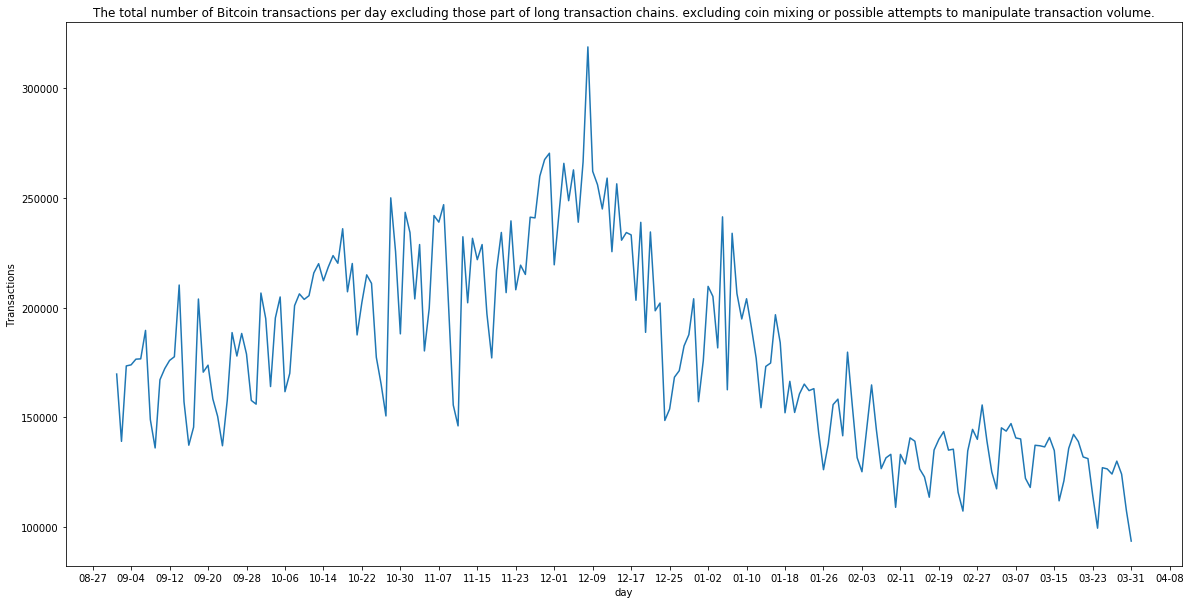

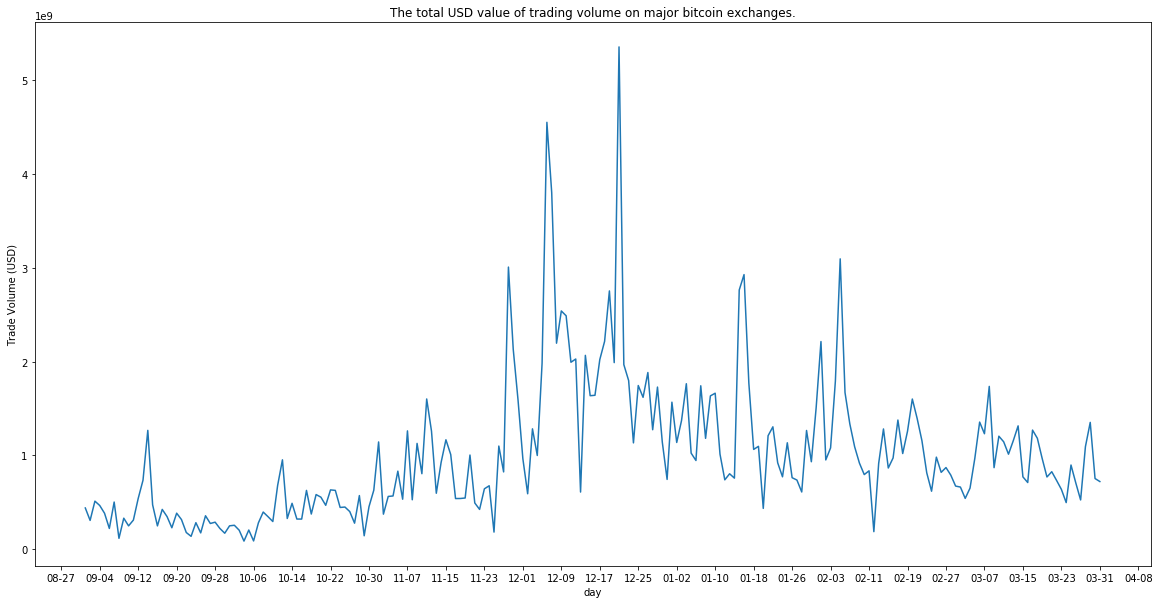

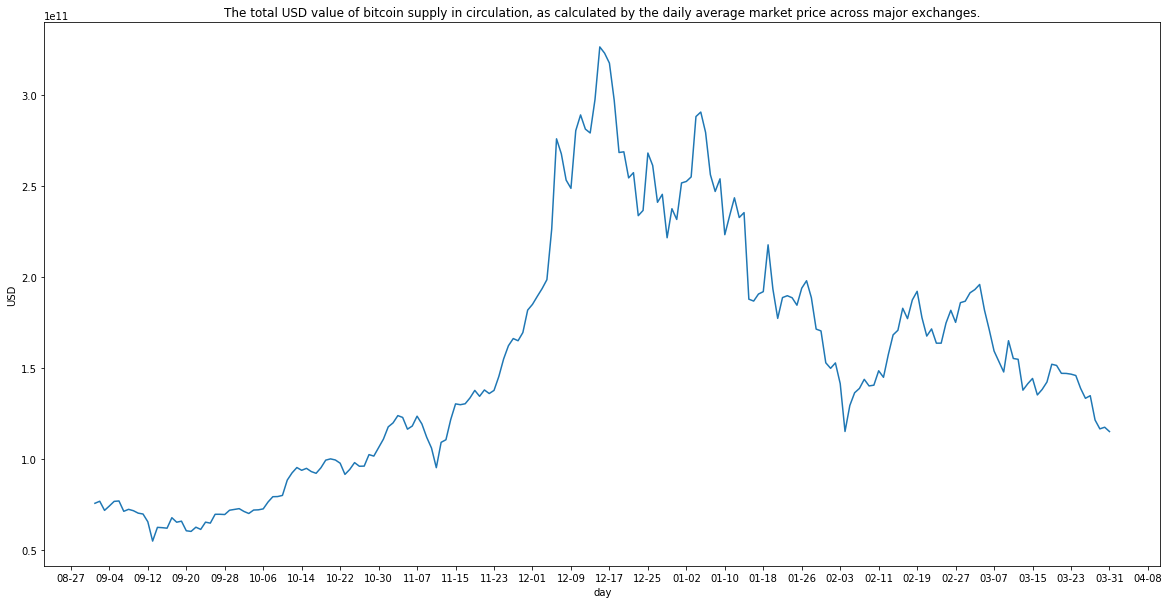

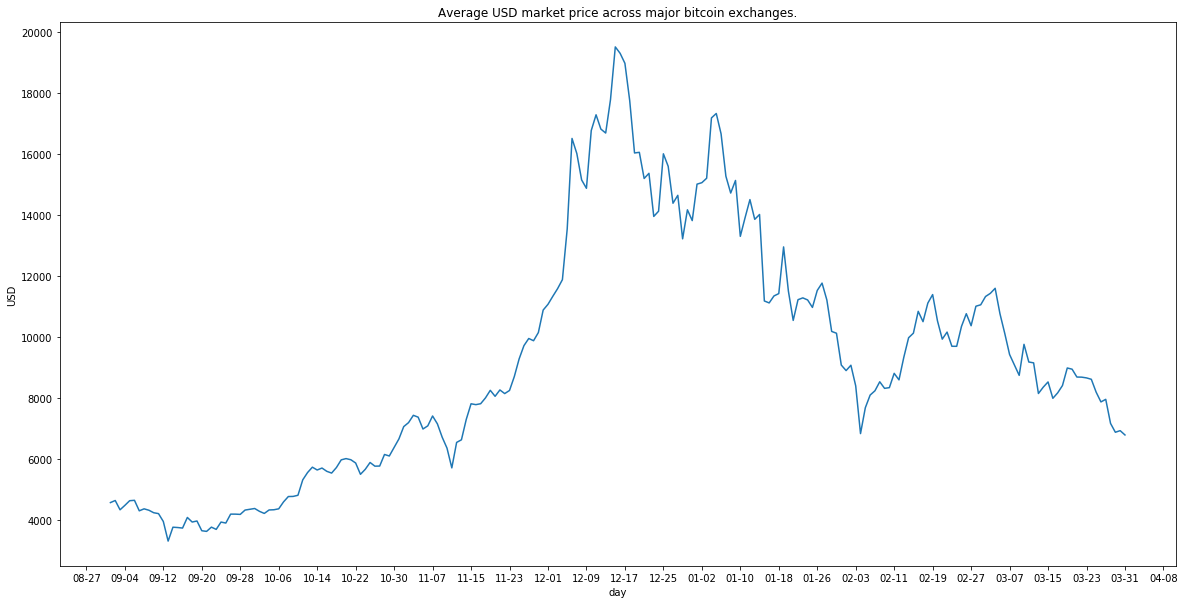

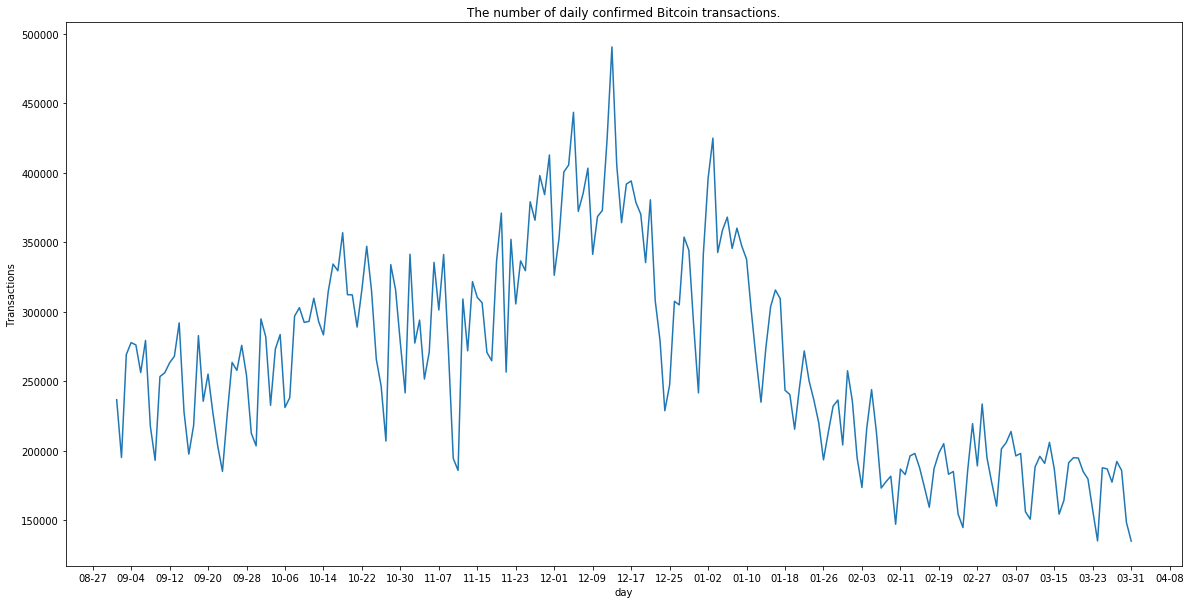

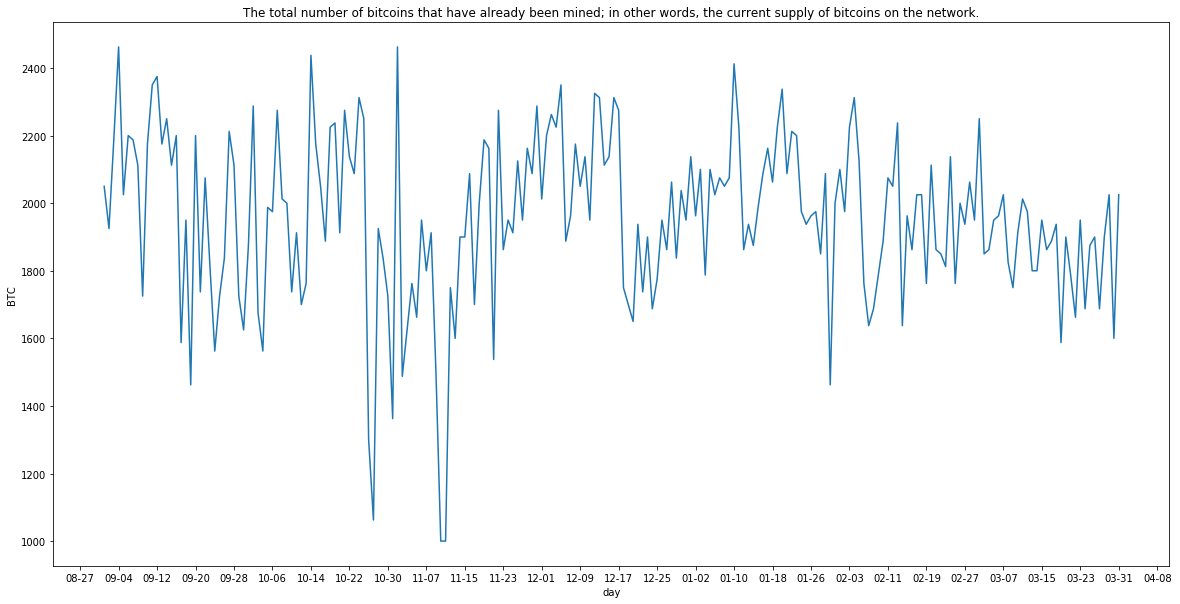

In [180]:
for k in timeseries_dict:
    plot_timeseries(start_date, end_date, timeseries_dict[k])

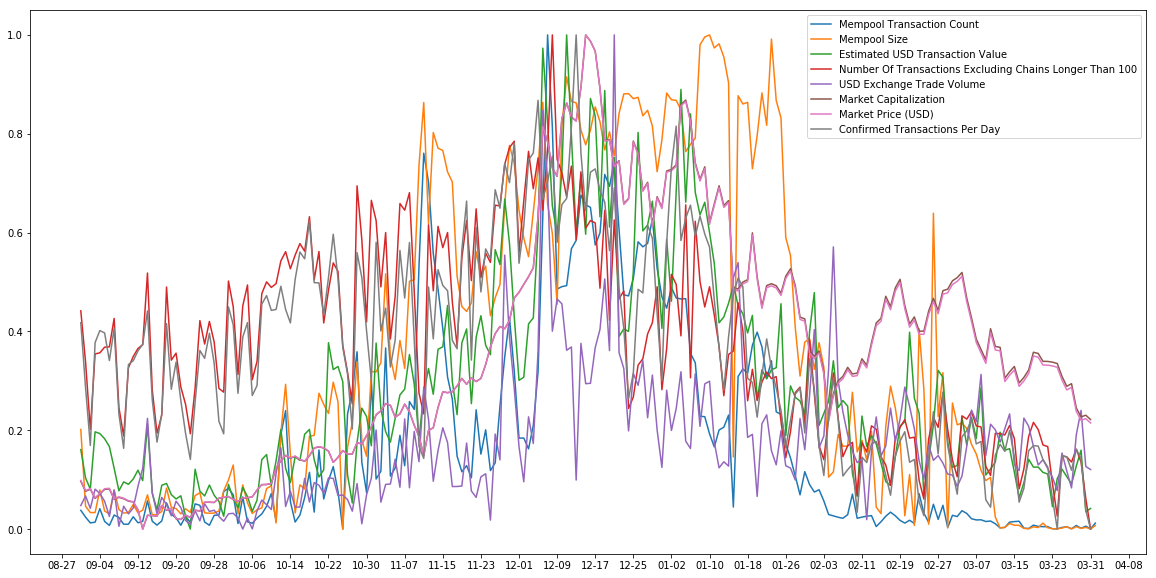

In [197]:
##plt all timeseries means in one chart
fig, ax = plt.subplots(figsize=(20,10))
for k in timeseries_dict:
    norm_values_dict = timeseries_dict[k].normalized_values_dict
    plt.plot(norm_values_dict.keys(), norm_values_dict.values(), label=timeseries_dict[k].name)

format_xdata = mdates.DateFormatter('%m-%d')
max_yticks = 30
xloc = plt.MaxNLocator(max_yticks)
ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(format_xdata)
plt.legend()

plt.show()
fig.savefig("plots/All_btc_timeseries_20170901_20180331.png", dpi=fig.dpi)